## Authenticates and initializes Earth Engine

In [1]:
import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()
    
import geemap

import os
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from cycler import cycler
from skimage.filters import threshold_otsu
from skimage import measure
import pandas as pd

## Specify a ROI and create a Map

Order of coordinates: bottom left, top left, top right, bottom right

Coords: [longitude, latitude]

In [2]:
Map = geemap.Map()
roi = ee.Geometry.Polygon(
  [[[38.988041, 8.30037],
    [38.988041, 8.486557],
    [39.169084, 8.486557],
    [39.169084, 8.30037]]], None, False)

Map.centerObject(ee_object=roi, zoom=12)
Map.add_basemap("TERRAIN")
Map

Map(center=[8.393461223691679, 39.07856249999964], controls=(WidgetControl(options=['position'], widget=HBox(c…

## Calls Sentinel optical imagery

Checking how many Sentinel images are available over the study area and sorting by cloud cover and clipping by ROI.
Firstly parameters are defined

More information on Sentinel dataset: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#description

In [3]:
Start_period = ee.Date('2000-01-01');
date_today = date.today().strftime('%Y-%m-%d')
End_period = ee.Date(date_today);

Sentinel_images = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(roi) \
    .filterDate(Start_period, End_period) \
    .filter('CLOUDY_PIXEL_PERCENTAGE < 2') \
    .filterMetadata('MGRS_TILE','equals','37PEK') \
    .sort('system:time_start') \
    .map(lambda image: image.unmask(-9999).clip(roi))

## Extracting information from the Sentinel collection

- define the number of all collected images
- extract the date from each image of the collection
- add all images in a list
- to easily retrieve specific info (e.g. projection, image dimension etc.) and
- to call a specified image from the collection

In [4]:
# number of all collected images
nbr = Sentinel_images.size().getInfo()
print(nbr)

# extract the date from an image collection 
dates = Sentinel_images.aggregate_array('system:time_start').map(lambda d: ee.Date(d).format('YYYY-MM-dd'))
Sentinel_dates = dates.getInfo()
print(Sentinel_dates)

# Retrieving info from images
# This is a way to get the images from the collection 
listOfImages = Sentinel_images.toList(Sentinel_images.size())

firstImage = ee.Image(listOfImages.get(12))
band2 = firstImage.select('B2')

gen_info = band2.getInfo()['bands'][0] 
print('General image properties included in a dictionary: ')
print(gen_info)

# Projection, crs, dimension
proj = band2.projection().getInfo()
crs = proj['crs']
dim =gen_info.get('dimensions')
print(dim)

firstImage_props = geemap.image_props(firstImage)
print(proj)

24
['2018-12-15', '2018-12-25', '2019-01-04', '2019-01-09', '2019-01-14', '2019-01-19', '2019-01-24', '2019-01-29', '2019-02-03', '2019-02-28', '2019-03-10', '2019-03-15', '2019-03-20', '2019-03-25', '2019-10-26', '2019-10-31', '2020-01-09', '2020-01-19', '2020-02-08', '2020-04-08', '2020-05-13', '2020-10-05', '2020-10-30', '2020-11-24']
General image properties included in a dictionary: 
{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -9999, 'max': 65535}, 'dimensions': [1864, 2060], 'origin': [0, 6192], 'crs': 'EPSG:32637', 'crs_transform': [10, 0, 499980, 0, -10, 1000020]}
[1864, 2060]
{'type': 'Projection', 'crs': 'EPSG:32637', 'transform': [10, 0, 499980, 0, -10, 1000020]}


## Visualise the first Sentinel image

- Natural Color (B4, B3, B2)
- False Color Infrared (B8, B4, B3)
- Land/Water: (B8, B11, B4)
...

In [5]:
# Visualise one Sentinel image
sent_vis = {'bands': ['B4', 'B3', 'B2'],'gain': [0.05, 0.05, 0.05]}
Map.addLayer(Sentinel_images.first(),sent_vis, 'Sentinel first')
#Map # not need to call unless you want to add a seperate interactive map window. 

## Resample each image in the collection without downloading- 10 m pixel resolution

Bicubic resampling is used.
There are other more complex approaches but downloading all images is required (e.g. superres @ https://nicolas.brodu.net/recherche/superres/)

In [6]:
newList = ee.List([])
for i in range(nbr):
    Im= ee.Image(listOfImages.get(i)).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A','B11', 'B12' ])
    print (str(i)+'_resampling......')
    Im_10m = Im.resample('bicubic').reproject(crs=crs, scale=10) # resampling
    List_bands = Im_10m.bandNames().getInfo()
    newList = newList.add(Im_10m)

Sentinel_10m = ee.ImageCollection(newList) 

# to generate a list so I can call each image seperately
listOfImages_10m = Sentinel_10m.toList(Sentinel_10m.size())

0_resampling......
1_resampling......
2_resampling......
3_resampling......
4_resampling......
5_resampling......
6_resampling......
7_resampling......
8_resampling......
9_resampling......
10_resampling......
11_resampling......
12_resampling......
13_resampling......
14_resampling......
15_resampling......
16_resampling......
17_resampling......
18_resampling......
19_resampling......
20_resampling......
21_resampling......
22_resampling......
23_resampling......


## Calculate MNDWI index and add as a separate band

MNDWI: Modified Normalised Difference Water Index

more info: https://developers.google.com/earth-engine/tutorials/tutorial_api_06

In [7]:
# definition of MNDWI
def add_mndwi(img):
    mndwi = img.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    return img.addBands(mndwi)

## Add the water index as a separate band in all images of the collection

- Create a new list of Images that includes the water index band for all epochs
- Print out info to check that the water index has been added

In [8]:
# add MNDWI for all images in the imagecollection
Sentinel_10m = Sentinel_10m.map(add_mndwi)

# number of all collected images
nbr = Sentinel_10m.size().getInfo()
print(nbr)
# to generate a new list that also includes the water index band just computed
listOfImages_updated = Sentinel_10m.toList(Sentinel_10m.size())
# just check that the index is included in one image of the collection
test= ee.Image(listOfImages_updated.get(21))
test_props = geemap.image_props(test)
test_props.getInfo()

24


{'AOT_RETRIEVAL_ACCURACY': 0,
 'CLOUDY_PIXEL_PERCENTAGE': 0.174319,
 'CLOUD_COVERAGE_ASSESSMENT': 0.174319,
 'CLOUD_SHADOW_PERCENTAGE': 0.039741,
 'DARK_FEATURES_PERCENTAGE': 0.387938,
 'DATASTRIP_ID': 'S2B_OPER_MSI_L2A_DS_VGS2_20201005T102029_S20201005T075242_N02.14',
 'DATATAKE_IDENTIFIER': 'GS2B_20201005T073749_018708_N02.14',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1601893229000,
 'GEOMETRIC_QUALITY': 'PASSED',
 'GRANULE_ID': 'L2A_T37PEK_A018708_20201005T075242',
 'HIGH_PROBA_CLOUDS_PERCENTAGE': 0.092637,
 'IMAGE_DATE': '2020-10-05',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1': 189.871937742626,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B10': 191.404984759365,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B11': 189.637609378034,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B12': 189.030620932487,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2': 194.493253036691,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3': 192.059167070571,
 'MEAN_INCIDENCE_AZI

## Inspect  the water index alongside image collection

In [9]:
index_vis = {'bands': ['MNDWI'], min: -1, max: 1, 'palette': ['white','green', 'cyan', 'blue']}
Map2 = geemap.Map()
Map2.ts_inspector(left_ts=Sentinel_10m, right_ts=Sentinel_10m, left_names=Sentinel_dates, right_names=Sentinel_dates, left_vis=sent_vis, right_vis=index_vis)
Map2.add_basemap("TERRAIN")
Map2.centerObject(ee_object=roi, zoom=12)
Map2

Map(center=[8.393461223691679, 39.07856249999964], controls=(WidgetControl(options=['position'], widget=Dropdo…

## Functions:

- convert ee.Image to 1D array (https://gis.stackexchange.com/questions/344932/export-image-collection-to-pixel-value-across-bands) that helps to extract the digital pixel values to make histograms and dictionaries
- unsupervised clasification weka kmeans with 5 clusters (https://developers.google.com/earth-engine/apidocs/ee-clusterer-wekakmeans?hl=en)

In [10]:
region = ee.FeatureCollection(roi)

def im2array1D(image, bandname):
    # extract the data from an ee.image
    im = image.select(bandname)
    # extract the pixel values from the image
    info = im.reduceRegion(ee.Reducer.toList(), geometry = region, scale = 10)

    # Convert to an 1D array for further use
    data = np.array((ee.Array(info.get(bandname)).getInfo()))
    return data
    
def add_kmeans(image):
    # Unsupervised classification
    # Make the training dataset.
    training = image.sample(**{
        'region': region,
        'scale': 10,
        'numPixels': 5000,
        'seed': 0,
        'geometries': True  # Set this to False to ignore geometries
    })
    # Instantiate the clusterer and train it.
    n_clusters = 5
    clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)
    # Cluster the input using the trained clusterer.
    kmeans = image.cluster(clusterer).rename('kmeans5')
    return kmeans

## Apply the k means using all bands and the water index

- to apply the k means each image myst be called in a for loop
- dictionaries for the clustering result and the mndwi values are generated
- an updated list of all clustered images for all epochs is created

In [11]:
# Unsupervised classification using the Water index 
# save the cluster result in a dictionary
# save also the MNDWI values in a seperate dictionary

dict_kmeans5 = {} #  empty dictionary for clustering
dict_mndwi = {} #  empty dictionary for mndwi values
newList = ee.List([])
for i in range(nbr):
    Im= ee.Image(listOfImages_updated.get(i))
    result = add_kmeans(Im) #+ Sentinel_dates[i])
    
    # add kmeans clusters for all images in a seperate imagecollection
    waterkmeans = Im.addBands(result)
    test_props = geemap.image_props(waterkmeans)
    test_props = waterkmeans.getInfo()['bands']
    print(str(i))
    print('-----------------')
    #print(test_props)
    newList = newList.add(waterkmeans)
    
    # generate dictionaries per image
    # add each cluster result per image (date) in a dictionary
    cluster_labels= im2array1D(waterkmeans, 'kmeans5')
    dict_kmeans5 [Sentinel_dates[i]] = cluster_labels
    
    # add each MNDWI result per image (date) in a dictionary
    mndwi_data= im2array1D(Im, 'MNDWI')
    dict_mndwi [Sentinel_dates[i]] = mndwi_data
        
    print(Sentinel_dates[i])

waterkmeans_collection = ee.ImageCollection(newList)
listOfwaterkmeans = waterkmeans_collection.toList(waterkmeans_collection.size())

0
-----------------
2018-12-15
1
-----------------
2018-12-25
2
-----------------
2019-01-04
3
-----------------
2019-01-09
4
-----------------
2019-01-14
5
-----------------
2019-01-19
6
-----------------
2019-01-24
7
-----------------
2019-01-29
8
-----------------
2019-02-03
9
-----------------
2019-02-28
10
-----------------
2019-03-10
11
-----------------
2019-03-15
12
-----------------
2019-03-20
13
-----------------
2019-03-25
14
-----------------
2019-10-26
15
-----------------
2019-10-31
16
-----------------
2020-01-09
17
-----------------
2020-01-19
18
-----------------
2020-02-08
19
-----------------
2020-04-08
20
-----------------
2020-05-13
21
-----------------
2020-10-05
22
-----------------
2020-10-30
23
-----------------
2020-11-24


## Visualisation for inspection of the resulting clusters

- colours have been assigned for legends and the clusters are 0-4
- visualisation per epoch that can be defined with i

In [12]:
legend_keys = ['0', '1', '2', '3', '4']
legend_colors = ['#FF00FF','#FFEF00', '#0000FF', '#00FFFF', '#008000'] 

i=0
Im = ee.Image(listOfwaterkmeans.get(i))

Map_class_test2 = geemap.Map()
Map_class_test2.add_basemap("TERRAIN")
Map_class_test2.addLayer(Im.select(['kmeans5']), {'min': 0, 'max': 4, 'palette': legend_colors}, 'Labelled clusters ' + str(Sentinel_dates[i]))
Map_class_test2.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')
Map_class_test2.centerObject(ee_object=roi, zoom=12)
Map_class_test2


Map(center=[8.393461223691679, 39.07856249999964], controls=(WidgetControl(options=['position'], widget=HBox(c…

## Generate and save histograms per epoch with colours based on the clusters

- histograms are plotted using dataframes
- the previously created disctionaries are converted to dataframes 
- the key to call the dictionaries corresponds to Sentinel dates

2018-12-15 -> [4 4 4 ... 0 0 0] -> [-0.3574124  -0.35071003 -0.34760523 ...  0.87240142  0.87042254
  0.870278  ]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


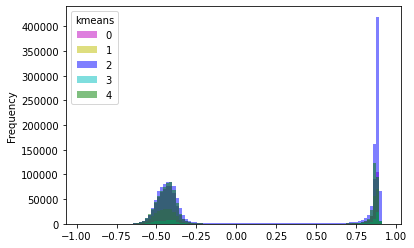

2018-12-25 -> [4 4 4 ... 1 0 4] -> [-0.35281384 -0.34458005 -0.34885401 ... -0.40022963 -0.39871088
 -0.38848263]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


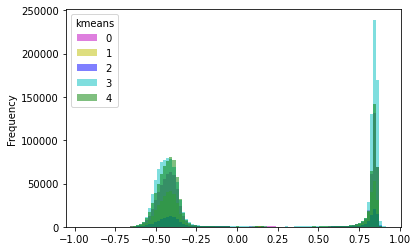

2019-01-04 -> [4 4 4 ... 3 3 3] -> [-0.35340503 -0.33724445 -0.33751568 ... -0.60543823 -0.5806613
 -0.47872779]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


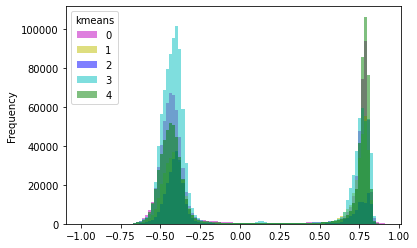

2019-01-09 -> [4 4 4 ... 3 3 3] -> [-0.47137636 -0.43155149 -0.41863444 ... -0.57685256 -0.60309678
 -0.49283352]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


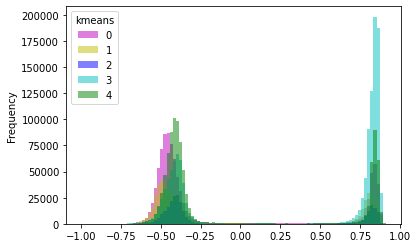

2019-01-14 -> [4 4 4 ... 3 0 4] -> [-0.43434343 -0.44384655 -0.42445031 ... -0.39529574 -0.39803609
 -0.39105016]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


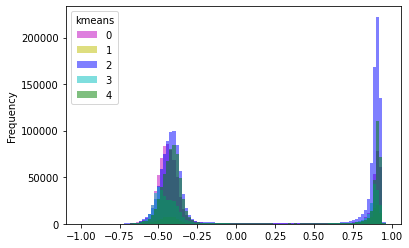

2019-01-19 -> [4 4 4 ... 0 0 4] -> [-0.42484662 -0.39934948 -0.43260303 ... -0.58928114 -0.57544029
 -0.44393179]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


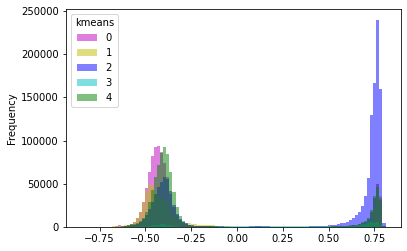

2019-01-24 -> [4 4 4 ... 0 0 4] -> [-0.41851512 -0.41628802 -0.41497797 ... -0.53146672 -0.5123986
 -0.41796875]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


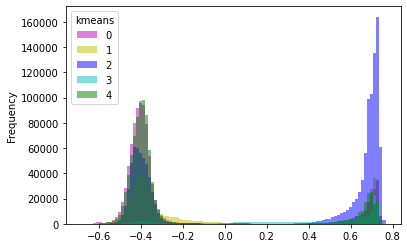

2019-01-29 -> [4 4 4 ... 3 3 3] -> [-0.40759772 -0.40362611 -0.38250309 ...  0.78723407  0.78759801
  0.7826404 ]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


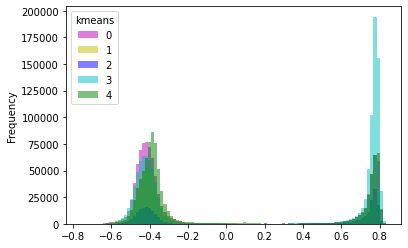

2019-02-03 -> [4 4 4 ... 1 0 4] -> [-0.43158662 -0.42077649 -0.4025836  ... -0.55053258 -0.53719741
 -0.43727666]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


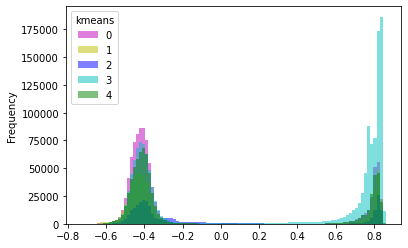

2019-02-28 -> [4 4 4 ... 4 4 4] -> [-0.40463459 -0.38456309 -0.38919666 ... -0.56140763 -0.55726534
 -0.44933078]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


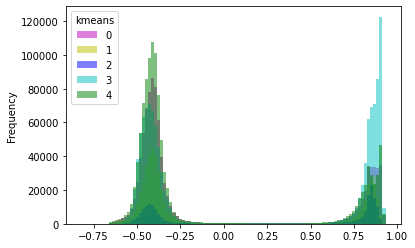

2019-03-10 -> [1 1 1 ... 1 1 1] -> [-0.32052267 -0.32912353 -0.33637583 ... -0.54472846 -0.46225563
 -0.33638775]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


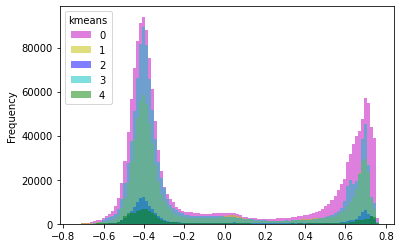

2019-03-15 -> [4 4 4 ... 0 0 4] -> [-0.43422914 -0.41708881 -0.41857243 ...  0.74619287  0.73565441
  0.73584908]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


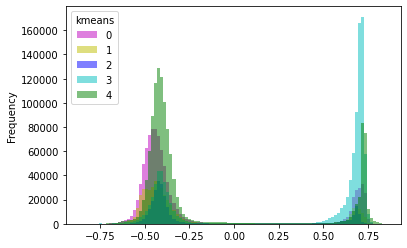

2019-03-20 -> [4 4 4 ... 0 0 4] -> [-0.38175312 -0.39210156 -0.41849899 ... -0.38658148 -0.39738926
 -0.44636983]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


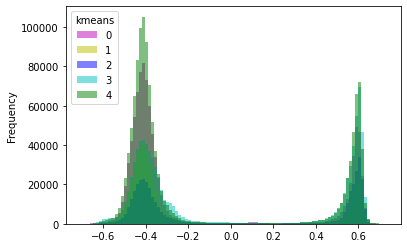

2019-03-25 -> [4 4 4 ... 0 0 0] -> [-0.37383342 -0.37748799 -0.37131906 ... -0.4887563  -0.44847849
 -0.36772293]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


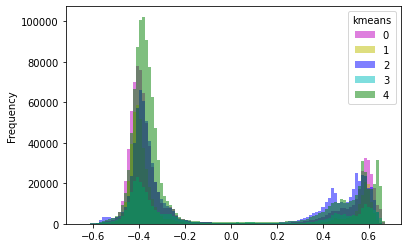

2019-10-26 -> [0 2 0 ... 3 3 3] -> [-0.57838607 -0.55708212 -0.5783022  ... -0.54486525 -0.60403728
 -0.61538464]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


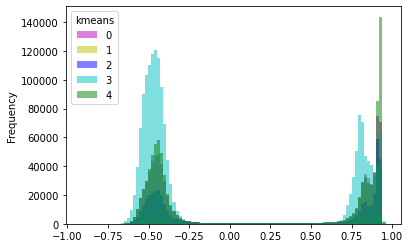

2019-10-31 -> [0 0 0 ... 3 3 3] -> [-0.40593237 -0.40883401 -0.41309449 ... -0.54776835 -0.59284294
 -0.5646711 ]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


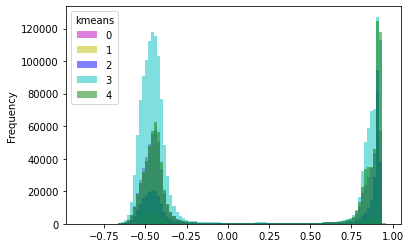

2020-01-09 -> [0 4 4 ... 3 0 0] -> [-0.47017014 -0.4864392  -0.4763158  ... -0.59910196 -0.61960667
 -0.54597276]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


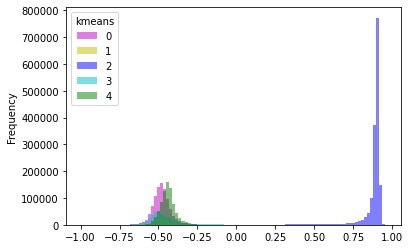

2020-01-19 -> [4 4 0 ... 0 0 0] -> [-0.45431146 -0.48438188 -0.48235294 ... -0.58567929 -0.61648542
 -0.52732503]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


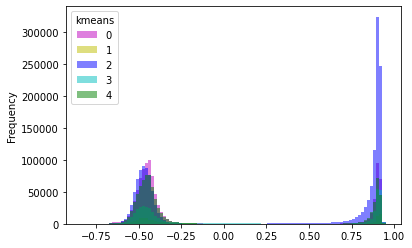

2020-02-08 -> [4 4 4 ... 1 1 4] -> [-0.45633507 -0.48210075 -0.48628646 ...  0.82685071  0.82749999
  0.83013022]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


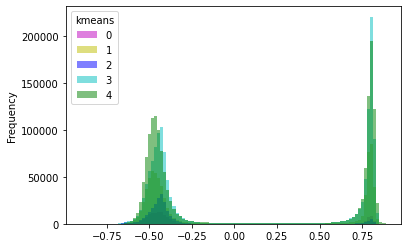

2020-04-08 -> [0 0 0 ... 4 4 4] -> [-0.41982454 -0.42824945 -0.43266693 ... -0.55976206 -0.53368133
 -0.45037514]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


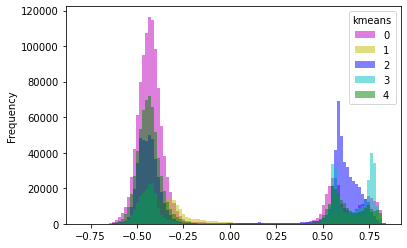

2020-05-13 -> [0 0 0 ... 2 2 2] -> [-0.45710874 -0.43277591 -0.46134886 ... -0.53626567 -0.53540587
 -0.47261873]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


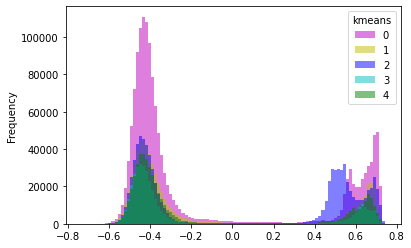

2020-10-05 -> [1 1 1 ... 1 1 1] -> [-0.31787032 -0.34504792 -0.33886871 ...  0.92658228  0.92536372
  0.92395437]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


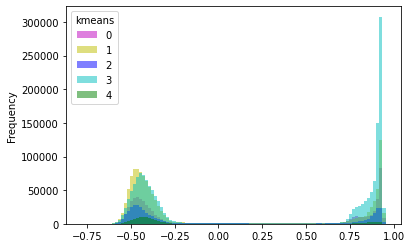

2020-10-30 -> [2 0 0 ... 3 3 3] -> [-0.36600626 -0.37166899 -0.37300745 ... -0.56094486 -0.6179775
 -0.6281296 ]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


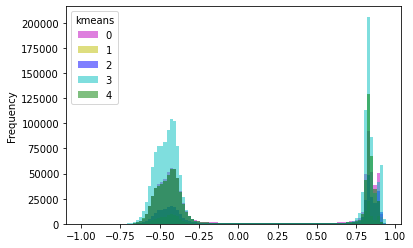

2020-11-24 -> [1 1 1 ... 2 2 2] -> [-0.34799039 -0.34111989 -0.34214187 ...  0.91226953  0.91260922
  0.90903264]
the shape of kmeans array is:   (3834206,)
the shape of mndwi 1Darray is:    (3834206,)


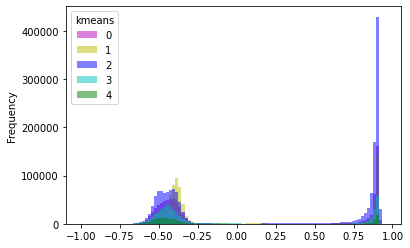

Histograms are completed


In [13]:
# set up the colors per cluster 
mpl.rcParams['axes.prop_cycle'] = cycler(color='mybcg') # 'bgrcmyk'

# loop through the dictionaries created previously
for key in dict_kmeans5:
    print(key, '->', dict_kmeans5[key], '->', dict_mndwi[key])
    print('the shape of kmeans array is:  ', dict_kmeans5[key].shape)
    print('the shape of mndwi 1Darray is:   ', dict_mndwi[key].shape)
    
    # generate a dataframe of the classes
    df = pd.DataFrame(dict_mndwi[key])
    df['kmeans'] = dict_kmeans5[key]
    df.columns = ['mndwi', 'kmeans']

    # pivot and then plot histogram with colours of the clusters
    fig1 = df.pivot(columns='kmeans',values='mndwi').plot.hist(bins=100, alpha = 0.5)
    
    plt.show()
print('Histograms are completed')

##  Thresholding with Otsu

-  Nobuyuki Otsu (1979). "A threshold selection method from gray-level histograms". IEEE Trans. Sys. Man. Cyber. 9 (1): 62–66. doi:10.1109/TSMC.1979.4310076.

- Otsu's method provides succesfull results with sharp bimodal histograms
- By inspecting the histograms and the clustering result we can exclude those clusters not related to waterbody and not using them for thresholding

In [14]:
# cluster to mask are those categories that will be masked out and not taken into consideration in the thresholding 

def thresholdOtsu(cluster_to_mask,index):
    # cluster_to_mask: clusters to be masked out
    replace = -9999.0 #  to use for replacing the values masked out
    cluster_labels = dict_kmeans5[Sentinel_dates[index]]
    mask = np.isin(cluster_labels, cluster_to_mask)
    
    # get a copy of the water index and mask it
    mndwi_1Dar = dict_mndwi [Sentinel_dates[index]]
    band_masked = mndwi_1Dar.copy()
    band_masked[mask]= replace
    # update the mask by removing the big values
    band_masked2 = band_masked[band_masked != replace]

    # local thresholding
    local_otsu = threshold_otsu(band_masked2)
    
    # get only the unique values of the masked cluster
    clusters5 = [0,1,2,3,4]
    unique_clusters = list(set(clusters5)-set(cluster_to_mask))
    return local_otsu

# test for the 1st image
cluster_to_mask = [0,4]
threshold_value = thresholdOtsu(cluster_to_mask,0) # 0 corresponds to image i=0
print(threshold_value)

0.21648662828374654


## Function to extract the water boundary after applying thresholding and estimate the water surface area

In [15]:
def extract_water_boundary(img, threshold_value):
    # create raster using thresholding
    water_image = img.gt(threshold_value).selfMask()
    # convert raster to vector 
    Water_boundary_vector = water_image.reduceToVectors(scale=10, maxPixels=10e10)
    lake_boundary= Water_boundary_vector.filterBounds(img.geometry().bounds())
    area = lake_boundary.geometry().area(1).divide(1e6).round().getInfo()
    return lake_boundary, area

## Calculate water boundary and area 
 - apply the previous function

In [16]:
# calculate water boundary vectors and areas using otsu's thresholding
area_list = []
for i in range(nbr):
    Im = ee.Image(listOfwaterkmeans.get(i))
    mndwi_img = Im.select(['MNDWI'])
    cluster_to_mask = [0,4]
    threshold_value = thresholdOtsu(cluster_to_mask,i)
    lake_boundary, area = extract_water_boundary(mndwi_img, threshold_value)
    print(i, '->', str(Sentinel_dates[i]), '->', "Area = {} km2".format(area))
    area_list.append(area)
    
print('Finished')       

0 -> 2018-12-15 -> Area = 152 km2
1 -> 2018-12-25 -> Area = 151 km2
2 -> 2019-01-04 -> Area = 150 km2
3 -> 2019-01-09 -> Area = 148 km2
4 -> 2019-01-14 -> Area = 146 km2
5 -> 2019-01-19 -> Area = 144 km2
6 -> 2019-01-24 -> Area = 143 km2
7 -> 2019-01-29 -> Area = 142 km2
8 -> 2019-02-03 -> Area = 141 km2
9 -> 2019-02-28 -> Area = 132 km2
10 -> 2019-03-10 -> Area = 122 km2
11 -> 2019-03-15 -> Area = 125 km2
12 -> 2019-03-20 -> Area = 123 km2
13 -> 2019-03-25 -> Area = 119 km2
14 -> 2019-10-26 -> Area = 165 km2
15 -> 2019-10-31 -> Area = 164 km2
16 -> 2020-01-09 -> Area = 159 km2
17 -> 2020-01-19 -> Area = 157 km2
18 -> 2020-02-08 -> Area = 154 km2
19 -> 2020-04-08 -> Area = 133 km2
20 -> 2020-05-13 -> Area = 121 km2
21 -> 2020-10-05 -> Area = 158 km2
22 -> 2020-10-30 -> Area = 156 km2
23 -> 2020-11-24 -> Area = 156 km2
Finished


## Generate a figure with the estimated Area

<ipython-input-17-7ab2a52719b2>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(Sentinel_dates, rotation = 90, ha="right")


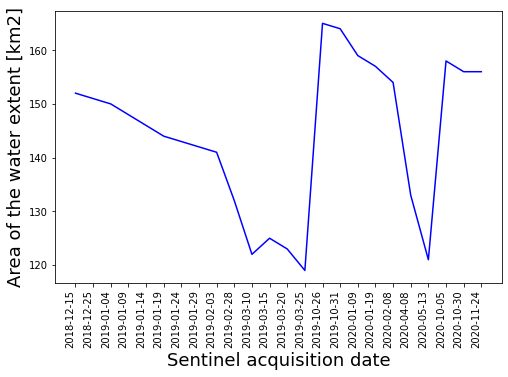

In [17]:
# Make a figure with Area
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Area of the water extent [km2]', fontsize=18)
ax1.set_xlabel('Sentinel acquisition date', fontsize=18)
ax1.plot(Sentinel_dates, area_list, 'b-')
ax1.set_xticklabels(Sentinel_dates, rotation = 90, ha="right")
ax1 = plt.gca()  

## Visualise the water line per image defining its number i

In [20]:
i=0
Im = ee.Image(listOfwaterkmeans.get(i))
mndwi_img = Im.select(['MNDWI'])
cluster_to_mask = [0,4]
threshold_value = thresholdOtsu(cluster_to_mask,i)
lake_boundary, area = extract_water_boundary(mndwi_img, threshold_value)

Map_class_test2 = geemap.Map()
Map_class_test2.add_basemap("TERRAIN")
Map_class_test2.addLayer(Im.select(['kmeans5']), {'min': 0, 'max': 4, 'palette': legend_colors}, 'Labelled clusters ' + str(Sentinel_dates[i]))
Map_class_test2.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')
Map_class_test2.addLayer(ee.Image().paint(lake_boundary, 0, 2), {'palette': 'black'}, 'Lake Outline  '+ str(Sentinel_dates[i]))
Map_class_test2.centerObject(ee_object=roi, zoom=12)
Map_class_test2

Map(center=[8.393461223691679, 39.07856249999964], controls=(WidgetControl(options=['position'], widget=HBox(c…